# 1. 导入我们需要用到的包，此教程 包含可视化以及模型训练和测试

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

# 2. 对于demo，尝试模型，我们可以用自己模拟的数据或者公开数据集，这里为了方便，采用自己模拟sin函数，并可视化

In [7]:
x = torch.linspace(0, 999, 1000)
y = torch.sin(x*2*3.1415926/70)

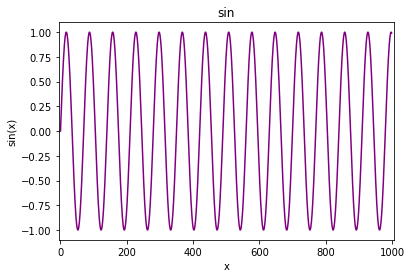

In [8]:
plt.xlim(-5, 1005)
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.title("sin")
plt.plot(y.numpy(), color='#800080')
plt.show()

# 3. 分训练集和测试集，并且需要对数据进行time windows分割

In [9]:
def create_data_seq(seq, time_window):
    out = []
    l = len(seq)
    for i in range(l-time_window):
        x_tw = seq[i:i+time_window]
        y_label = seq[i+time_window:i+time_window+1]
        out.append((x_tw, y_label))
    return out
time_window = 50
data = create_data_seq(y, time_window)

In [10]:
data[1]

(tensor([ 8.9639e-02,  1.7856e-01,  2.6604e-01,  3.5137e-01,  4.3388e-01,
          5.1290e-01,  5.8779e-01,  6.5794e-01,  7.2279e-01,  7.8183e-01,
          8.3457e-01,  8.8060e-01,  9.1953e-01,  9.5106e-01,  9.7493e-01,
          9.9095e-01,  9.9899e-01,  9.9899e-01,  9.9095e-01,  9.7493e-01,
          9.5106e-01,  9.1953e-01,  8.8060e-01,  8.3457e-01,  7.8183e-01,
          7.2280e-01,  6.5794e-01,  5.8779e-01,  5.1290e-01,  4.3388e-01,
          3.5137e-01,  2.6604e-01,  1.7856e-01,  8.9639e-02,  1.5100e-07,
         -8.9639e-02, -1.7856e-01, -2.6604e-01, -3.5137e-01, -4.3388e-01,
         -5.1290e-01, -5.8779e-01, -6.5794e-01, -7.2279e-01, -7.8183e-01,
         -8.3457e-01, -8.8060e-01, -9.1953e-01, -9.5106e-01, -9.7493e-01]),
 tensor([-0.9909]))

In [11]:
len(data)

950

In [12]:
# train: test = 4：1
train_data = data[:int(0.8*len(data))]
test_data = data[int(0.8*len(data)):]

In [13]:
len(train_data), len(test_data)

(760, 190)

# 4. 定义lstm模型
https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM

https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear

In [14]:
class MyLstm(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, out_size=1):
        super(MyLstm, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=self.hidden_size, num_layers=1, bidirectional=False)
        self.linear = nn.Linear(in_features=self.hidden_size, out_features=out_size, bias=True)
        self.hidden_state = (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))
        
    def forward(self, x):
        out, self.hidden_state = self.lstm(x.view(len(x), 1, -1), self.hidden_state)
        pred = self.linear(out.view(len(x), -1))
        return pred[-1]

# 5. 训练准备工作
(1) 超参数

(2) 定义loss，优化器，实例化模型

In [15]:
learning_rate = 0.00001
epoch = 10

In [16]:
model = MyLstm()
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5,0.999))

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
device

device(type='cuda', index=0)

In [19]:
model.to(device)

MyLstm(
  (lstm): LSTM(1, 128)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

Epoch 0 Loss: 0.10417673736810684
Performance on test range: 0.449596107006073


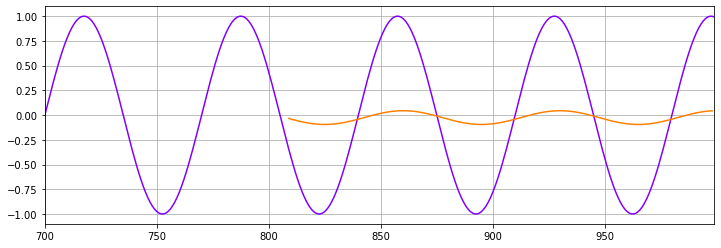

Epoch 1 Loss: 0.13313084840774536
Performance on test range: 0.32084062695503235


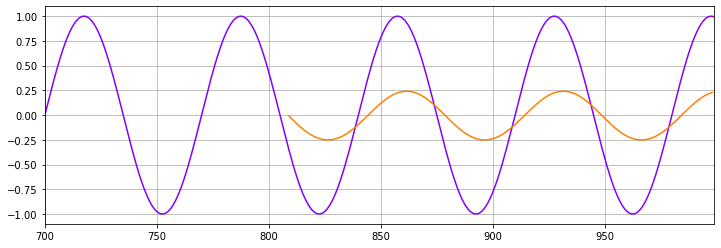

Epoch 2 Loss: 0.21179334819316864
Performance on test range: 0.19783569872379303


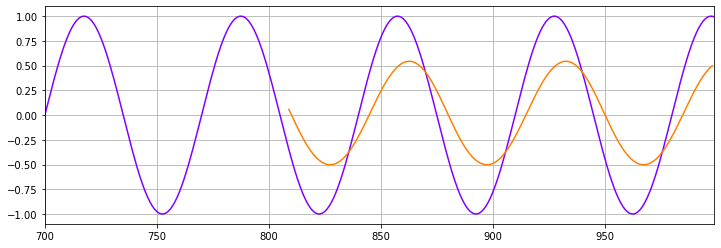

Epoch 3 Loss: 0.1682671755552292
Performance on test range: 0.1210491880774498


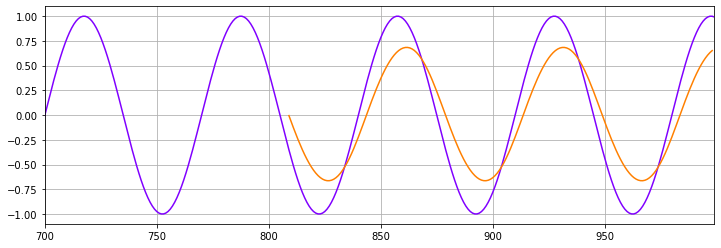

Epoch 4 Loss: 0.09070781618356705
Performance on test range: 0.052346087992191315


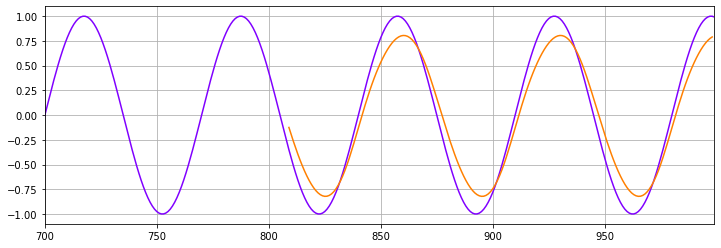

Epoch 5 Loss: 0.020414091646671295
Performance on test range: 0.013524227775633335


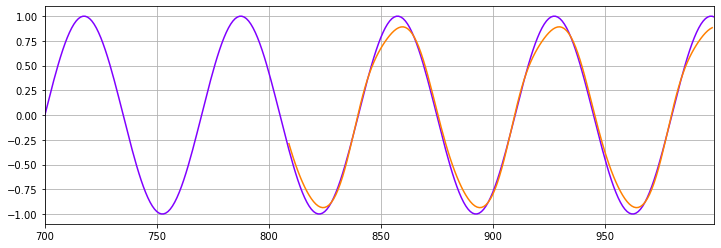

Epoch 6 Loss: 0.001979721710085869
Performance on test range: 0.0023358974140137434


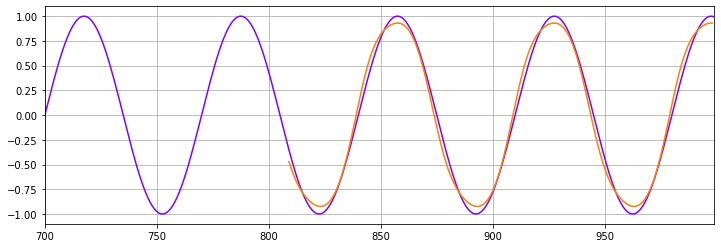

Epoch 7 Loss: 0.0022776236291974783
Performance on test range: 0.0015511990059167147


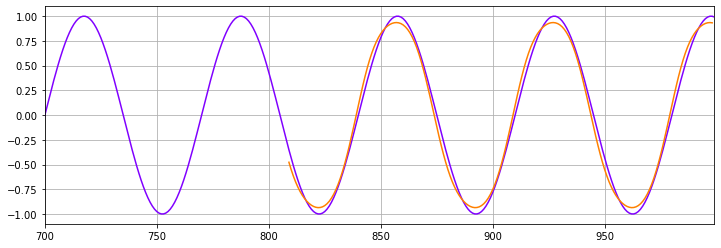

Epoch 8 Loss: 0.0016302436124533415
Performance on test range: 0.0011019367957487702


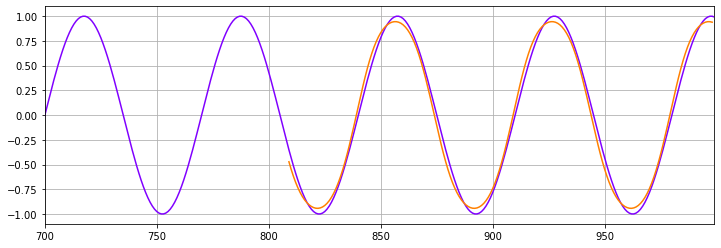

Epoch 9 Loss: 0.0010898986365646124
Performance on test range: 0.0007791818934492767


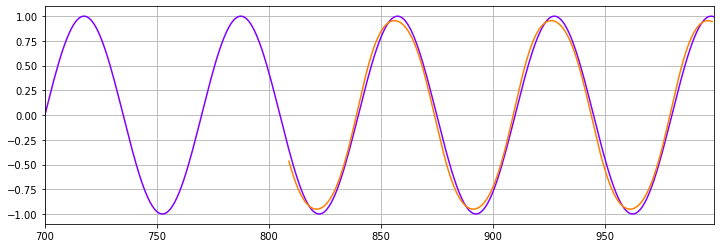

In [20]:
for i in range(epoch):
    for x_seq, y_label in train_data:
        x_seq = x_seq.to(device)
        y_label = y_label.to(device)
        model.hidden_state = (torch.zeros(1, 1, model.hidden_size).to(device), 
                              torch.zeros(1, 1, model.hidden_size).to(device))
        pred = model(x_seq)
        loss = mse_loss(y_label, pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {i} Loss: {loss.item()}")
    preds = []
    labels = []
    for j in range(len(test_data)):
        test_seq, test_label = test_data[j]
        test_seq = test_seq.to(device)
        test_label = test_label.to(device)
        with torch.no_grad():
            model.hidden_state = (torch.zeros(1, 1, model.hidden_size).to(device), 
                              torch.zeros(1, 1, model.hidden_size).to(device))
            preds.append(model(test_seq).item())
            labels.append(test_label.item())
    loss = mse_loss(torch.tensor(preds), torch.tensor(labels))
    print(f"Performance on test range: {loss}")
    
    plt.figure(figsize=(12,4))
    plt.xlim(700,999)
    plt.grid(True)
    plt.plot(y.numpy(),color='#8000ff')
    plt.plot(range(999-190,999),preds,color='#ff8000')
    plt.show()